In [61]:
import os
import random
import math
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf

# for tokenizing
nltk.download('punkt')

# for POS tagging
from nltk.tag.perceptron import AveragedPerceptron
from nltk.tag.perceptron import PerceptronTagger


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
def load_data(path):
  """Return a list of tokenized sentence, and
      a dictionary of frequency of word
    
    Args:
      path: the path of the file (in txt) to parse and tokenize
  """
  f = open(path, "r")
  text = f.read()
  token_dict = dict()

  # documents -> list of sentences
  sentences_lst = nltk.sent_tokenize(text)

  # list of sentences -> list of tokenized sentences
  tokenized_sentences = []
  for sentence in sentences_lst:
    tokenized = nltk.word_tokenize(sentence)
    tokenized_sentences.append(tokenized)
    for token in tokenized:
      if token in token_dict:
        token_dict[token] += 1
      else:
        token_dict[token] = 1

  return tokenized_sentences, token_dict

In [10]:
def merge_dict(dict1, dict2):
  """Return a new dictionary with the content of dict1 and dict2"""  
  res = {**dict1, **dict2}
  return res

In [11]:
def process_data():
    """Retun a list of tokenized sentences and a word frequency dictionary"""
    
    cwd = os.getcwd()
    categories = ["/businessEconomy", "/lifestyle", "/politics", "/technology"]

    tokenized_sentences = []
    word_freq_dict = dict()

    for category in categories:
        docs_list = os.listdir(cwd+category)
        for docs in docs_list:
            doc_path = cwd+category+"/"+docs
            tkn_sent, tkn_dict = load_data(doc_path)
            tokenized_sentences += tkn_sent
            word_freq_dict = merge_dict(word_freq_dict, tkn_dict)

    return tokenized_sentences, word_freq_dict        
        

In [12]:
tokenized_sentences, word_freq_dict = process_data()

In [78]:
tokenized_sentences[1]

['Salah',
 'satunya',
 'dengan',
 'program',
 'padat',
 'karya',
 'tunai',
 'yang',
 'saat',
 'ini',
 'realisasinya',
 'mencapai',
 '40',
 '%',
 'dan',
 'diperkirakan',
 'menyerap',
 '1,2',
 'juta',
 'tenaga',
 'kerja',
 '.']

In [13]:
tagged_data = tf.keras.utils.get_file(fname="tagged_tsv_gh", origin="https://raw.githubusercontent.com/famrashel/idn-tagged-corpus/master/Indonesian_Manually_Tagged_Corpus_ID.tsv")

In [73]:
class PrepareData():
    def __init__(self, path):
        self.tagged_data = path
        self.pos_tags = dict()
        self.data = []
        self.pos_tags_set = set()

    def load(self):
        f = open(self.tagged_data, "r")
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line[:2] == "</":
                # end of a sentence
                self.data.append(tagged_entry)
            elif line[:1] == "<":
                # instantiate a new tagged entry
                tagged_entry = []
            else:
                lst = line.split("\t")
                word = lst[0]
                tag = lst[1]

                # add entry to tagged_entry to build tagged sentence
                entry = (word, tag)
                tagged_entry.append(entry)
                
                # add the tag and word to pos_tags
                if tag not in self.pos_tags:
                    self.pos_tags[tag] = set(word)
                else:
                    self.pos_tags[tag].add(word)

        self.pos_tags_set = set(self.pos_tags.keys())

    def split_test_train(self, ratio=0.8):
        """Split the data into test set and train set. Default ratio is 80% train and 20% test"""
        num_train_data = len(self.data)
        choose = math.floor(num_train_data * (1 - ratio))
        test_data = random.sample(self.data, choose)
        train_data = list(filter(lambda i: i not in test_data, self.data))
        return train_data, test_data
    
    def get_statistics(self):
        """Return a general report of the corpus statistics
            Statistics to return:
            - total number of sentences
            - average word count in a sentence
            - max sentence length
            - min sentence length
        """
        sent_list = []
        total_wc = 0
        freq_dict = dict() # key: word count, value: num of sentences with that word count
        word_count = lambda sentence: len(nltk.word_tokenize(sentence))
        
        for tagged_sent in self.data:
            sent = to_sent(tagged_sent)
            sent_list.append(sent)
            total_wc += word_count(sent)
            if word_count(sent) in freq_dict:
                freq_dict[word_count(sent)] += 1
            else:
                freq_dict[word_count(sent)] = 1
        
        min_sent = min(sent_list, key=word_count) # the shortest sentence by word count
        max_sent = max(sent_list, key=word_count) # the longest sentence by word count
        min_wc = word_count(min_sent)
        max_wc = word_count(max_sent)
        average_wc = math.floor(total_wc / len(sent_list))
        print("CORPUS STATISTICS")
        print(f"There are a total of {len(sent_list)} sentences in the corpus from {self.tagged_data}\n")
        print(f"\tAverage word count\t:\t{average_wc}\n")
        print(f"\tmaximum sentence length\t:\t{max_wc}\n")
        print(f"\tsentence:\n")
        print(f"\t{max_sent}\n")
        print(f"\tminimum sentence length\t:\t{min_wc}\n")
        print(f"\tsentence:\n")
        print(f"\t{min_sent}\n")

        plt.figure(figsize=(10, 7.5))
        plt.bar(freq_dict.keys(), freq_dict.values(), width=0.75)

In [63]:
def to_sent(tagged_sent):
    """Return a sentence from a tagged sentence version"""
    sent = ""
    for (word, tag) in tagged_sent:
        sent += word + " "
    return sent.strip()

def get_tag(tagged_sent, word_to_tag):
    """Retrieve the POS tag of a word in a tagged sentence"""
    for (word, tag) in tagged_sent:
        if word_to_tag == word:
            return tag
    return f"{word_to_tag} is not in the sentence"

In [74]:
prepare_data = PrepareData(tagged_data)
prepare_data.load()
train_data, test_data = prepare_data.split_test_train()
data = prepare_data.data

In [65]:
print(to_sent(train_data[15]))
print(get_tag(train_data[15], "sudah"))

Dua miliarder Amerika Bill Gates dan Warren Buffett akan mengadakan jamuan makan malam di Beijing bagi sejumlah orang terkaya di Cina .
sudah is not in the sentence


CORPUS STATISTICS
There are a total of 10030 sentences in the corpus from /root/.keras/datasets/tagged_tsv_gh

	Average word count	:	26

	maximum sentence length	:	83

	sentence:

	Dikatakan -nya , inflasi terjadi karena adanya kenaikan harga yang ditunjukkan oleh kenaikan indeks pada kelompok barang dan jasa , yaitu kelompok bahan makanan 1,87 persen , kelompok makanan jadi , minuman , rokok & tembakau 0,51 persen , kelompok perumahan , air , listrik , gas & bahan bakar 0,21 persen , kelompok sandang 2,05 persen , kelompok kesehatan 0,45 persen , kelompok pendidikan , rekreasi dan olahraga 0,21 persen , dan kelompok transpor , komunikasi & jasa keuangan 0,47 persen .

	minimum sentence length	:	2

	sentence:

	Calon selebriti



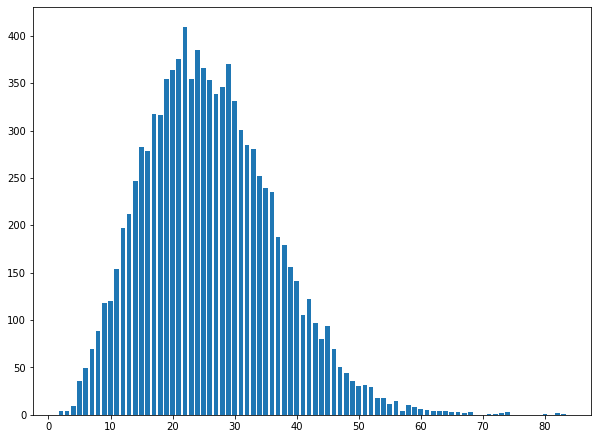

In [75]:
prepare_data.get_statistics()

In [42]:
default_modal = set(["akan", "ingin", "mau", "telah", "sudah", "pernah", "masih", "bisa", "dapat", "boleh", "ikut", "harus", "suka", "senang"])

In [56]:
def get_modal(data, default_modal):
    """Return the sentences that contains auxiliary verb from the prepared data
        and the set of modal / auxiliary words

        Args:
            train_data: from the corpus of tagged words
            default_modal: a set of default modal words that will be used 
                to detect possible modal that is not labeled as modal

        Return data will be a dictionary:
            key: modal words
            values: list of sentences containing the modal words (no repeat)
    """
    f = open("report.txt", "w")
    modal_sent_dict = dict()
    num_misclassified_modal = 0
    for sentence in data:
        for entry in sentence:
            word = entry[0]
            tag = entry[1]
            if tag == "MD":
                if word not in modal_sent_dict:
                    modal_sent_dict[word] = [sentence]
                elif sentence not in modal_sent_dict[word]:
                    modal_sent_dict[word].append([sentence])    
            elif word in default_modal:
                f.write(f"the word {word} is a modal but not tagged as MD\n")
                f.write(f"\t{word} is classified as {tag}\n")
                f.write(f"\tin sentence {sentence}\n")
                f.write("\n")
                num_misclassified_modal += 1
    f.close()
    print(f"there are {num_misclassified_modal} instances where modal words that are not classified as modal")
    print(f"there are {len(modal_sent_dict.keys())} modal words")
    print(f"{modal_sent_dict.keys()}")
    # for each modal words in the key set, make the value to a set then back to list
    

In [57]:
get_modal(data, default_modal)

there are 131 instances where modal words that are not classified as modal
there are 39 modal words
dict_keys(['akan', 'bisa', 'harus', 'telah', 'sudah', 'baru', 'mulai', 'pernah', 'masih', 'sempat', 'sedang', 'tengah', 'mau', 'sepertinya', 'perlu', 'boleh', 'dapat', 'mungkin', 'bakal', 'kemungkinan', 'sedikit', 'Baru', 'Bisa', 'hendak', 'Mungkin', 'Sudah', 'barangkali', 'Harus', 'Pernah', 'Masih', 'Akan', 'guna', 'Dapat', 'usah', 'mesti', 'kan', 'Telah', 'lagi', 'Perlu'])


In [45]:
perceptron_tagger = PerceptronTagger(load=False)

In [46]:
# RUN THIS IF YOU WANT TO RETRAIN
perceptron_tagger.train(train_data, save_loc="trained_model_split_80.pickle")

In [12]:
# LOAD THE SAVED MODEL
perceptron_tagger.load("trained_model.pickle")

In [ ]:
def detect_auxiliary(tokenized_sentences):
    """Detect auxiliary verbs or modal verbs'""